In [9]:
import os

from importlib import reload

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)

from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder


import flow.visualize.visualize_ring as visualize_ring
from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader


import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

import torch

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

model = get_cnn_lstm_ae_model(n_features=4)

print('Loaded libraries for detection.')

Loaded libraries for detection.


In [ ]:
def train_i24_model(timeseries_dict,n_epoch=300,model=None,seq_len=100):
    veh_ids = list(timeseries_dict.keys())
    timeseries_list = []

    for veh_id in veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        num_samples = len(timeseries_dict[veh_id][:,0])
        if(num_samples > seq_len):
            speed = timeseries_dict[veh_id][:,1]
            accel = np.gradient(speed,.1)
            head_way = timeseries_dict[veh_id][:,2]
            rel_vel = timeseries_dict[veh_id][:,3]
            
#             for i in range(len(head_way)):
#                 if(head_way[i] > 200.0):
#                     head_way[i] = 200.0
#                     rel_vel[i] = 0.0

            timeseries_list.append([speed,accel,head_way,rel_vel])
        
    train_X = make_train_X(timeseries_list,seq_len=seq_len)
    
    if(model is None):
        model = get_cnn_lstm_ae_model(n_features=4,seq_len=seq_len)
    
    model_file_name = 'i24_detector_no_position_seq_len_'+str(seq_len)
    
    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch,seq_len=seq_len)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model

In [26]:
import csv
import numpy as np
import sys
def get_sim_timeseries(csv_path,warmup_period=0.0):
    row_num = 1
    curr_veh_id = 'id'
    sim_dict = {}
    curr_veh_data = []

    id_index = 0
    time_index = 0
    speed_index = 0
    headway_index = 0
    relvel_index = 0
    edge_index = 0
    x_index = 0
    y_index = 0
    position_index = 0



    edge_list = ['Eastbound_3',':202186118','Eastbound_4','Eastbound_5','Eastbound_6',':202186134','Eastbound_7',':202236780','Eastbound_8']

    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')

        row1 = next(csvreader)
        num_entries = len(row1)
        while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
        while(row1[edge_index]!='edge_id' and edge_index<num_entries):edge_index +=1
        while(row1[time_index]!='time' and time_index<num_entries):time_index +=1
        while(row1[speed_index]!='speed' and speed_index<num_entries):speed_index +=1
        while(row1[headway_index]!='headway' and headway_index<num_entries):headway_index +=1
        while(row1[relvel_index]!='leader_rel_speed' and relvel_index<num_entries):relvel_index +=1
        while(row1[x_index]!='x' and x_index<num_entries):x_index +=1
        while(row1[y_index]!='y' and y_index<num_entries):y_index +=1
        while(row1[position_index]!='relative_position' and position_index<num_entries):position_index +=1


        for row in csvreader:
            if(row_num > 1):
                # Don't read header
                if(curr_veh_id != row[id_index]):
                    #Add in new data to the dictionary:

                    #Store old data:
                    if(len(curr_veh_data)>0):
                        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
                        sys.stdout.write('\r'+'Veh id: '+curr_veh_id+ ' row: ' +str(row_num)+'\r')
                    #Rest where data is being stashed:
                    curr_veh_data = []
                    curr_veh_id = row[id_index] # Set new veh id
                    #Allocate space for storing:

                curr_veh_id = row[id_index]
                time = float(row[time_index])
                edge = row[edge_index]
                
                
                if(time > warmup_period and edge in edge_list):
                    # data = [time,speed,headway,leader_rel_speed,x,y]
                    if(edge == 'Eastbound_8'):
                        position = float(row[position_index])
                        if(position < 250):
                            data = [row[time_index],row[speed_index],row[headway_index],row[relvel_index],row[x_index],row[y_index]]
                            curr_veh_data.append(data)
                    else:
                        data = [row[time_index],row[speed_index],row[headway_index],row[relvel_index],row[x_index],row[y_index]]
                        curr_veh_data.append(data)
                    
            row_num += 1

        #Add the very last vehicle's information:
        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
        print('Data loaded.')
    return sim_dict

def train_i24_model(timeseries_dict,n_epoch=300,model=None,seq_len=100):
    veh_ids = list(timeseries_dict.keys())
    timeseries_list = []

    for veh_id in veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        num_samples = len(timeseries_dict[veh_id][:,0])
        if(num_samples > seq_len):
            speed = timeseries_dict[veh_id][:,1]
            accel = np.gradient(speed,.1)
            head_way = timeseries_dict[veh_id][:,2]
            rel_vel = timeseries_dict[veh_id][:,3]
            
            for i in range(len(head_way)):
                if(head_way[i] > 200.0):
                    head_way[i] = 200.0
                    rel_vel[i] = 0.0

            timeseries_list.append([speed,accel,head_way,rel_vel])
        
    train_X = make_train_X(timeseries_list,seq_len=seq_len)
    
    if(model is None):
        model = get_cnn_lstm_ae_model(n_features=4,seq_len=seq_len)
    
    model_file_name = 'i24_detector_no_position_seq_len_'+str(seq_len)
    
    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch,seq_len=seq_len)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model
    
print('Training procedure defined.')

Training procedure defined.


In [20]:
import time
csv_path = '/Volumes/Backup/George_Research/benign_initial_i24/1800_inflow_0.2_ACC.csv'
warmup_period = 1200.0

begin_load_time = time.time()
timeseries_dict = get_sim_timeseries(csv_path,warmup_period)
end_load_time = time.time()

print('Total loading time: '+str(end_load_time-begin_load_time))

Data loaded._60.647 row: 4714684
Total loading time: 28.800753116607666


1582
flow_70.617


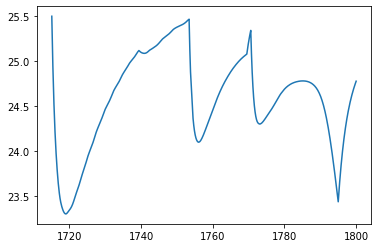

In [22]:
import matplotlib.pyplot as plt
veh_ids = list(timeseries_dict.keys())
print(len(veh_ids))
veh_id = veh_ids[1400]
print(veh_id)
# print(timeseries_dict[veh_id])
plt.plot(timeseries_dict[veh_id][:,0],timeseries_dict[veh_id][:,1])

In [27]:
seq_len = 200

i24_detection_model = train_i24_model(timeseries_dict,n_epoch=40,model=None,seq_len=seq_len)

Beginning training...
Creating new model.
Best loss 710.344416838681
Beginning training.
Number epochs: 0 epoch step time: 119.63578295707703
Epoch 0, total loss 3413720.215393, total predictions 14950, avg loss 228.342489 2022-06-17 14:35:10.170859
Saving model. Best loss: 228.34248932395093
Number epochs: 1 epoch step time: 119.08268976211548
Number epochs: 2 epoch step time: 122.2138147354126
Number epochs: 3 epoch step time: 122.22184991836548
Number epochs: 4 epoch step time: 128.5994110107422
Saving model. Best loss: 194.3318977258995
Number epochs: 5 epoch step time: 131.90479397773743
Epoch 5, total loss 2286284.727661, total predictions 14950, avg loss 152.928744 2022-06-17 14:45:34.194144
Saving model. Best loss: 152.92874432515939
Number epochs: 6 epoch step time: 136.3772578239441
Saving model. Best loss: 146.7385672007277
Number epochs: 7 epoch step time: 134.05749893188477
Saving model. Best loss: 130.7468530416329
Number epochs: 8 epoch step time: 130.87732887268066
Numb

In [28]:
i24_detection_model = train_i24_model(timeseries_dict,n_epoch=20,model=None,seq_len=seq_len)

Beginning training...
Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/models/cnn_lstm_ae_i24_detector_no_position_seq_len_200.pt
Best loss 83.92865857995075
Beginning training.
Number epochs: 0 epoch step time: 121.05891990661621
Epoch 0, total loss 1395382.113876, total predictions 14950, avg loss 93.336596 2022-06-17 16:03:18.309215
Number epochs: 1 epoch step time: 123.54077291488647
Saving model. Best loss: 72.17000126459128
Number epochs: 2 epoch step time: 125.13610315322876
Number epochs: 3 epoch step time: 124.8598039150238
Number epochs: 4 epoch step time: 123.5720808506012
Number epochs: 5 epoch step time: 124.24039602279663
Epoch 5, total loss 1101235.787781, total predictions 14950, avg loss 73.661257 2022-06-17 16:13:39.659035
Number epochs: 6 epoch step time: 121.11639285087585
Number epochs: 7 epoch step time: 128.75385904312134
Number epochs: 8 epoch step time: 146.18097019195557
Number epochs: 9 epoch step time: 125.82891702651978


In [34]:
import flow.visualize.visualize_ring as visualize_ring
reload(visualize_ring)

from scipy.signal import savgol_filter

from time import time as timer_start

def get_data_for_AE(timeseries_dict,veh_id):
    timeseries_data = timeseries_dict[veh_id]
    speed = timeseries_dict[veh_id][:,1]
    speed_smoothed = savgol_filter(speed,21,3)
    accel = np.gradient(speed_smoothed,.1)
    head_way = timeseries_dict[veh_id][:,2]
    rel_vel = timeseries_dict[veh_id][:,3]
    timeseries_data_list = [speed,accel,head_way,rel_vel]

    return timeseries_data_list


def get_losses_complete_obs(timeseries_dict,model,seq_len=200,warmup_period=1200):

    begin_time = time.time()

    veh_ids = list(timeseries_dict.keys())
   
    num_veh_processed = 0
    
    total_vehicles = len(veh_ids)

    testing_losses_dict = {}

    for veh_id in veh_ids:
        
        speed = timeseries_dict[veh_id][:,1]
        
        if(len(speed) > seq_len):
#             accel = np.gradient(speed,.1)
#             head_way = timeseries_dict[veh_id][:,2]
#             rel_vel = timeseries_dict[veh_id][:,3]

            timeseries_list = get_data_for_AE(timeseries_dict,veh_id)

            _,loss = sliding_window_mult_feat(model,timeseries_list,seq_len=seq_len)

            testing_losses_dict[veh_id]=loss

        num_veh_processed+=1

        if(num_veh_processed % 100 == 0):
            total_compute_time = time.time()-begin_time
            sys.stdout.write('\r'+'Vehicles processed: '+str(num_veh_processed)+'/'+str(total_vehicles)+', total compute time: '+str(total_compute_time)+'\r')
        
    print('\n')
    
    smoothed_losses = {}
    
    #Get smoothed loss values:
    
    for veh_id in testing_losses_dict:
        loss = testing_losses_dict[veh_id]
        if(loss is not None):
            vehicles_time = timeseries_dict[veh_id][:,0]
            smoothed_losses[veh_id] =  [vehicles_time,loss_smooth(vehicles_time,loss)]
    
    print('Total time to calculate loses: '+str(time.time()-begin_time))
    
    return smoothed_losses

print('Defined functions for doing anomaly detection.')

Defined functions for doing anomaly detection.


In [31]:
# emission_path = '/Volumes/Backup/George_Research/i24_random_sample/part 1/Dur_9.717839924656609_Mag_-1.4249530669819752_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'

emission_path = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/data/Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'

timeseries_dict = get_sim_timeseries(csv_path=emission_path,warmup_period=warmup_period)



Data loaded._110.631 row: 6727804


In [36]:
model = get_cnn_lstm_ae_model(n_features=4,seq_len=200)
# Load in a trained model:
MODEL_PATH = os.path.join(os.getcwd(),'models/cnn_lstm_ae_i24_detector_no_position_seq_len_200.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

begin_time = time.time()

i24_losses_test = get_losses_complete_obs(timeseries_dict,model,seq_len=200,warmup_period=warmup_period)

end_time = time.time()

print('Total time: '+str(end_time-begin_time))

Vehicles processed: 1500/1578, total compute time: 5564.3638088703165



/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/Detectors/Deep_Learning/AutoEncoders/utils.py:196: RuntimeWarning: invalid value encountered in true_divide
  veh_losses_filtered = np.divide(veh_losses_filtered,loss_counts)


Total time to calculate loses: 5593.666415929794
Total time: 5593.668439149857


In [37]:
def write_losses_to_file(smoothed_losses,file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for veh_id in smoothed_losses:
            vehicle_times = smoothed_losses[veh_id][0]
            losses = smoothed_losses[veh_id][1]
            num_samples = len(losses)
            for i in range(num_samples):
                writer.writerow([veh_id,vehicle_times[i],losses[i]])
                
            
    print('Loss file written to csv.')

def get_sim_name(file_name):
    i = 0
    while(file_name[i:i+3] != 'Dur'):i+=1
    return file_name[i:]

file_name = 'Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1_losses_200seqlen.csv'

write_losses_to_file(i24_losses_test,file_name)

Loss file written to csv.


In [38]:
def get_sim_timeseries_all_data_i24(csv_path,warmup_period=0.0):
    row_num = 1
    curr_veh_id = 'id'
    sim_dict = {}
    curr_veh_data = []

    id_index = 0
    time_index = 0
    speed_index = 0
    headway_index = 0
    relvel_index = 0
    edge_index = 0
    x_index = 0
    y_index = 0
    position_index = 0
    
    edge_list = ['Eastbound_3',':202186118','Eastbound_4','Eastbound_5','Eastbound_6',':202186134','Eastbound_7',':202236780','Eastbound_8']

    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')

        row1 = next(csvreader)
        num_entries = len(row1)
        while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
        while(row1[edge_index]!='edge_id' and edge_index<num_entries):edge_index +=1
        while(row1[time_index]!='time' and time_index<num_entries):time_index +=1
        while(row1[speed_index]!='speed' and speed_index<num_entries):speed_index +=1
        while(row1[headway_index]!='headway' and headway_index<num_entries):headway_index +=1
        while(row1[relvel_index]!='leader_rel_speed' and relvel_index<num_entries):relvel_index +=1
        while(row1[x_index]!='x' and x_index<num_entries):x_index +=1
        while(row1[y_index]!='y' and y_index<num_entries):y_index +=1
        while(row1[position_index]!='relative_position' and position_index<num_entries):position_index +=1


        csvreader = csv.reader(csvfile, delimiter=',')
        id_index = 0
        time_index = 0
        row1 = next(csvreader)
        while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
        while(row1[time_index]!='time' and time_index<num_entries):time_index +=1

        row_num += 1

        for row in csvreader:
            if(row_num > 1):
                # Don't read header
                if(curr_veh_id != row[curr_veh_id]):
                    #Add in new data to the dictionary:

                    #Store old data:
                    if(len(curr_veh_data)>0):
                        sim_dict[curr_veh_id] = curr_veh_data
                    #Rest where data is being stashed:
                    curr_veh_data = []
                    curr_veh_id = row[curr_veh_id] # Set new veh id
                    #Allocate space for storing:
                    sim_dict[curr_veh_id] = []

                curr_veh_id = row[curr_veh_id]
                time = float(row[0])
                if(time > warmup_period):
                    # data = [time,speed,headway,leader_rel_speed]
                    curr_veh_data.append(row)
            row_num += 1

        #Add the very last vehicle's information:
        sim_dict[curr_veh_id] = curr_veh_data
        print('Data loaded.')
    return sim_dict

print('Defined function.')

Defined function.


In [39]:
csv_path_attack = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/data/Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'

all_sim_data_attack = get_sim_timeseries_all_data_i24(csv_path = csv_path_attack, warmup_period = warmup_period)

IndexError: list index out of range

In [ ]:
def load_loss_dict(file_name):
    loss_dict = {}
    with open(file_name, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        
        row = next(reader)
        curr_id = row[0]
        curr_losses = [row[2]]
        
        for row in reader:
            if(curr_id != row[0]):
                loss_dict[curr_id] = np.array(curr_losses).astype(float)
                curr_losses = []
                curr_id = row[0]
            
            curr_losses.append(row[2])
            
    return loss_dict
    

In [87]:
def process_file_for_losses(emission_file_path,loss_emission_repo,model,warmup_period=1200):
    i24_losses_test = get_losses_complete_obs(emission_file_path,model,warmup_period=warmup_period)
    sim_name = get_sim_name(emission_file_path)
    file_path_to_write = os.path.join(loss_emission_repo,sim_name)
    write_losses_to_file(i24_losses_test,file_path_to_write)
    return file_path_to_write
    
    
# loss_emission_repo = '/Volumes/Backup/George_Research/i24_random_sample/part 1/losses/'    
    
# emission_file_path = '/Volumes/Backup/George_Research/i24_random_sample/part 1/Dur_9.717839924656609_Mag_-1.4249530669819752_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'

# begin_time = time.time()
# process_file_for_losses(emission_file_path,loss_emission_repo,i24_detection_model_retrained,warmup_period=1780)
# end_time = time.time()
# print('Total processing time: '+str(end_time-begin_time))

# write_losses_to_file(i24_losses_test,file_name)

Data loaded, total time: 26.687623977661133
Vehicles processed: 300/377, time per step: 3.5940893939659664

Total time to calculate loses: 92.13576078414917
Loss file written to csv.
Total processing time: 92.36598706245422


# Experiment with detector that has positional knowledge

In [13]:
import csv
import numpy as np
import sys

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)

from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder


def get_sim_timeseries(csv_path,warmup_period=0.0):
    row_num = 1
    curr_veh_id = 'id'
    sim_dict = {}
    curr_veh_data = []
    
    edge_list = ['Eastbound_3','Eastbound_4','Eastbound_5','Eastbound_6','Eastbound_7']

    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if(row_num > 1):
                # Don't read header
                if(curr_veh_id != row[1]):
                    #Add in new data to the dictionary:

                    #Store old data:
                    if(len(curr_veh_data)>0):
                        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
                        sys.stdout.write('\r'+'Veh id: '+curr_veh_id+ ' row: ' +str(row_num)+'\r')
                    #Rest where data is being stashed:
                    curr_veh_data = []
                    curr_veh_id = row[1] # Set new veh id
                    #Allocate space for storing:
#                     sim_dict[curr_veh_id] = []

                curr_veh_id = row[1]
                time = float(row[0])
                edge = row[-4]
                if(time > warmup_period and edge in edge_list):
                    # data = [time,speed,headway,leader_rel_speed,x,y]
                    data = [row[0],row[4],row[5],row[8],row[2],row[3]]
                    curr_veh_data.append(data)
            row_num += 1

        #Add the very last vehicle's information:
        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
        print('Data loaded.')
    return sim_dict


def train_i24_model(timeseries_dict,n_epoch=60,model=None,seq_len=200):
    veh_ids = list(timeseries_dict.keys())
    timeseries_list = []
    
    
    x_origin = 5800
    y_origin = 21350

    for veh_id in veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        num_samples = len(timeseries_dict[veh_id][:,0])
        if(num_samples > seq_len):
            speed = timeseries_dict[veh_id][:,1]
            accel = np.gradient(speed,.1)
            head_way = timeseries_dict[veh_id][:,2]
            rel_vel = timeseries_dict[veh_id][:,3]
            x_vals = timeseries_dict[veh_id][:,4] - x_origin
            y_vals = timeseries_dict[veh_id][:,5] - y_origin

            timeseries_list.append([speed,accel,head_way,rel_vel,x_vals,y_vals])
        
    train_X = make_train_X(timeseries_list,seq_len=seq_len)
    
    if(model is None):
        model = get_cnn_lstm_ae_model(n_features=6,seq_len=seq_len)
    
    model_file_name = 'i24_detector_complete_obs_positional'
    
    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch,seq_len=seq_len)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model
    
print('Training procedure defined.')

Training procedure defined.


In [8]:
training_file_path = '/Volumes/Backup/George_Research/benign_initial_i24/1800_inflow_0.2_ACC.csv'
warump_period = 1200.0
timeseries_dict_training = get_sim_timeseries(csv_path=training_file_path,
                                              warmup_period=warump_period)


Data loaded._60.647 row: 4714685


In [14]:
train_i24_model(timeseries_dict_training,
                n_epoch=60,
                model=None,
                seq_len=200)

Beginning training...
Creating new model.
Best loss 18689.24545679209
Beginning training.
Number epochs: 0 epoch step time: 139.00355005264282
Epoch 0, total loss 256231443.878906, total predictions 14700, avg loss 17430.710468 2022-06-16 13:05:12.698260
Saving model. Best loss: 17430.710467952806
Number epochs: 1 epoch step time: 146.45975494384766
Saving model. Best loss: 16310.174010948129
Number epochs: 2 epoch step time: 144.49372029304504
Saving model. Best loss: 15244.240525616497
Number epochs: 3 epoch step time: 151.89895510673523
Saving model. Best loss: 14257.464796981292
Number epochs: 4 epoch step time: 136.01705408096313
Saving model. Best loss: 13366.590214445154
Number epochs: 5 epoch step time: 134.78955793380737
Epoch 5, total loss 184811990.019531, total predictions 14700, avg loss 12572.244219 2022-06-16 13:17:06.358804
Saving model. Best loss: 12572.24421901573
Number epochs: 6 epoch step time: 128.93833899497986
Saving model. Best loss: 11868.471113148384
Number e

KeyboardInterrupt: 